In [1]:
import eee

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

### Specify ensemble

This ensemble has three species:

hdna + 2IPTG <--> h + 2IPTG <--> l2e

+ `hdna` (our observable, with dG0 = 0 kcal/mol)
+ `h` (unobserved structure that does not bind to anything; dG0 = 5 kcal/mol)
+ `l2e` (unobserved structure that binds to 2 iptg molecules; dG0 = 5 kcal/mol)

At highly positive IPTG concentration (low concentration), `hdna` will be highly favored. At highly negative IPTG concentrations (high concentration), `l2e` is favored. 


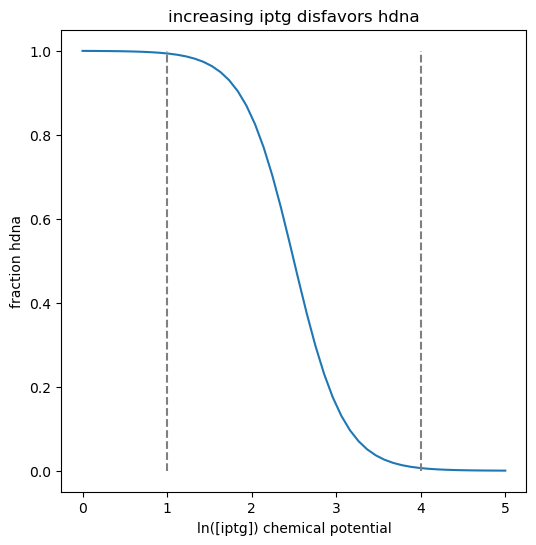

In [2]:
ens = eee.Ensemble()
ens.add_species("hdna",dG0=0,observable=True)
ens.add_species("h",dG0=5)
ens.add_species("l2e",dG0=5,mu_stoich={"iptg":2},observable=False)

df = ens.get_obs(mu_dict={"iptg":np.linspace(0,5)})
fig, ax = plt.subplots(1,figsize=(6,6))
ax.plot(df.iptg,df.fx_obs)
ax.set_xlabel("ln([iptg]) chemical potential")
ax.set_ylabel("fraction hdna")

ax.plot((1,1),(0,1),'--',color='gray')
ax.plot((4,4),(0,1),'--',color='gray')
ax.set_title("increasing iptg disfavors hdna")
None

### Load in $\Delta \Delta G$

Load in a spreadsheet with the energetics effects of mutations on all species in the ensemble. 

In [3]:
ddg_df = eee.io.load_ddg("../tests/data_for_tests/test_ddg/ddg.csv")
ddg_df

,site,mut,hdna,h,l2e
0,1,L1A,6.778,7.941,4.4385
1,1,L1C,8.147,11.205,7.6000
2,1,L1D,-0.234,1.073,3.2910
3,1,L1E,7.648,8.496,4.2360
4,1,L1F,1.447,4.023,-0.4560
...,...,...,...,...,...
75,4,G4S,15.472,35.673,20.0280
76,4,G4T,15.428,43.397,36.3300
77,4,G4V,24.131,39.590,45.7680
78,4,G4W,79.753,96.205,46.9070


### Simulate evolution

For this, we are going to use the `eee.evolve.simulate_evolution` function. First, see what it's arguments are.


In [4]:
help(eee.evolve.simulate_evolution)

Help on function simulate_evolution in module eee.evolve.simulate_evolution:

simulate_evolution(ens, ddg_df, mu_dict, fitness_fcns, select_on='fx_obs', fitness_kwargs={}, T=298.15, population_size=1000, mutation_rate=0.01, num_generations=100, write_prefix=None, write_frequency=1000)
    Simulate the evolution of a population where the fitness is determined by 
    the ensemble. 
    
    Parameters
    ----------
    ens : eee.Ensemble 
        initialized instance of an Ensemble class
    ddg_df : pandas.DataFrame
        pandas dataframe with columns holding 'mut', 'site' (i.e., the 21 in 
        A21P), 'is_wt' (whether or not the mutation is wildtype), and then 
        columns for the predicted ddG for each species. Generally should be
        created by util.load_ddg().
    mu_dict : dict, optional
        dictionary of chemical potentials. keys are the names of chemical
        potentials. Values are floats or arrays of floats. Any arrays 
        specified must have the same 

### Run evolutionary simulation

In this run, we select over 100 generations for the protein to be `on` for both $\mu _{iptg} = -4$ and $\mu _{iptg} = -1$. Our population size is 1000 and our mutation rate 0.01.

In [5]:
gc, generations = eee.evolve.simulate_evolution(ens=ens,
                                                        ddg_df=ddg_df,
                                                        mu_dict={"iptg":[1,4]},
                                                        fitness_fcns=[eee.evolve.ff_off,
                                                                      eee.evolve.ff_on],
                                                        select_on="fx_obs",
                                                        population_size=1000,
                                                        mutation_rate=0.01,
                                                        num_generations=1000)

  0%|          | 0/999 [00:00<?, ?it/s]

### Extract gentoype frequencies from the simulation

  0%|          | 0/1000 [00:00<?, ?it/s]

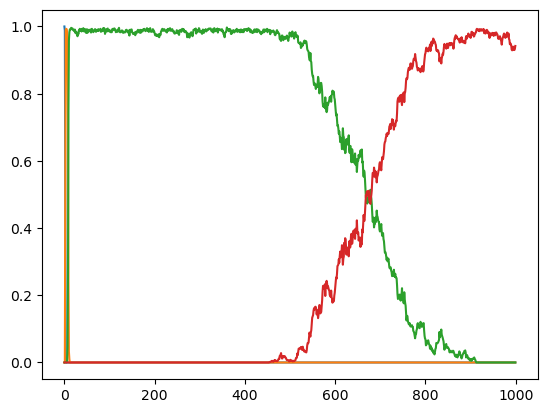

In [6]:
df = eee.evolve.get_genotype_frequencies(generations)
gen = np.arange(len(generations))
for x in df.columns:
    plt.plot(gen,df[x],'-')    
    

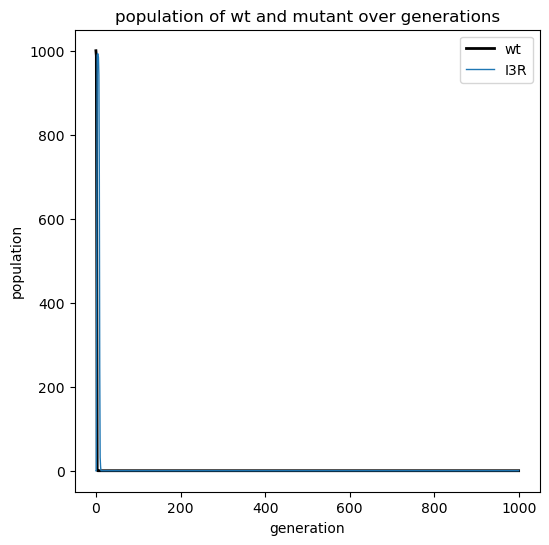

ValueError: mut_energy should be a dictionary that keys chemical species to effects of mutations


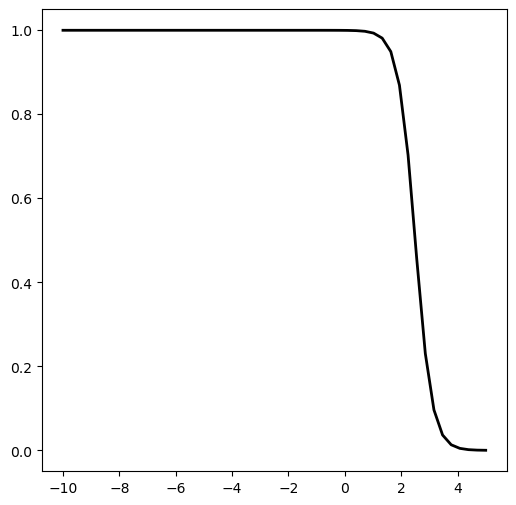

In [7]:

# Look for a genotype that becomes the most common genotype that is not 
# wt (0)
for generation in generations:
    genotypes = list(generation.keys())
    
    pops = []
    for g in genotypes:
        pops.append(generation[g])
    
    idx = np.argmax(pops)
    if genotypes[idx] != 0:
        mut_idx = genotypes[idx]
        break
        

wt_pop = []
mut_pop = []
for i, generation in enumerate(generations):

    try:
        wt_pop.append(generation[0])
    except KeyError:
        wt_pop.append(0)
        
    try:
        mut_pop.append(generation[mut_idx])
    except KeyError:
        mut_pop.append(0)
        
fig, ax = plt.subplots(1,figsize=(6,6))
ax.plot(np.arange(len(wt_pop)),wt_pop,'-',color="black",lw=2,label="wt")
ax.plot(np.arange(len(mut_pop)),mut_pop,'-',lw=1,label="/".join(gc.genotypes[mut_idx].mutations))
ax.set_xlabel("generation")
ax.set_ylabel("population")
ax.set_title("population of wt and mutant over generations")
ax.legend()   
plt.show()
        
        

        
fig, ax = plt.subplots(1,figsize=(6,6))

df = ens.get_obs(mu_dict={"iptg":np.linspace(-10,5)})
ax.plot(df.iptg,df.fx_obs,label="wt",color='black',lw=2)

mut_df = ens.get_obs(mut_energy=gc.genotypes[mut_idx].mut_energy,
                     mu_dict={"iptg":np.linspace(-10,5)})
ax.plot(mut_df.iptg,
        mut_df.fx_obs,
        '-',
        lw=1,
        label="/".join(gc.genotypes[mut_idx].mutations))
ax.set_xlabel("iptg chemical potential")
ax.set_ylabel("fraction hdna")
ax.set_title("new mutant response to IPTG")

ax.plot((-1,-1),(0,1),'--',color='gray')
ax.plot((-4,-4),(0,1),'--',color='gray')
ax.legend()   
None
    

In [ ]:
gc.df.to_csv("junk.csv")

In [ ]:
import pandas as pd
pd.read_csv("junk.csv")

In [ ]:
import pickle
with open('yo.pickle','wb') as f:
    pickle.dump(generations,f)

In [ ]:
with open('yo.pickle','rb') as f:
    x = pickle.load(f)
x